# __The O-Index:__ _A comprehensive rating of how open a scientist is with their publications_
#### Authors: Jennifer Jahncke, Emily Lecy, Tania Miramontes, Emily Pickup

## Description 

This project started in Neurohackademy, Seattle in August 2023 (http://neurohackademy.org/). The goal of this project is to create an automated interface where you can type an author name, and be given an o-index.

The O-index is a value assigned to a scientist to represent how much open science an author contributes to. This index is created by weighing openness of both data, code, and manuscript availability.

This project was initially inspired by a past project, the O-factor: https://github.com/srcole/o-factor, which gives journals an openness factor, in attempt to inspire open access initiatives.

### STEP 1: Find all papers contributed to by an author of interest:
***
We start by placing an authors name into our application. This name will be searched on pubmed, and the citations related to said author will be scraped for pubmed IDs.



In [1]:
#import packages
import requests
from bs4 import BeautifulSoup
from re import *
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Get PMCID from PMID
def get_pmcid_year(pmid):
    base_url = f"https://pubmed.ncbi.nlm.nih.gov/{pmid}/"
    response = requests.get(base_url)
    soup = BeautifulSoup(response.content, 'html.parser')
    date = soup.find_all('span', {'class' : 'cit'})[0].text.strip()
    date = split("\D", date)[0]
    try:
        pmcid = soup.find_all('a', {'class' : 'id-link', 'data-ga-action' : 'PMCID'})[0].text.strip()
    except:
        pmcid = None
    return (pmcid , date)


# Get PMIDs, Openness from author name
def get_pmids_open(author):
    
    # Parse author name, build first+last
    author = author.split()
    if len(author) > 1:
        aname = author[0]
        for name in author[1:]:
            aname += "+" + name
    else:
        aname = author[0]
        
    #find total number of pages
    base_url= f'https://pubmed.ncbi.nlm.nih.gov/?term={aname}&page='
    response = requests.get(base_url)
    soup = BeautifulSoup(response.content, 'html.parser')
    pages = soup.find_all('label', {'class' : 'of-total-pages'})
    p = pages[0].text.strip()
    p = p.split()
    pagenum=int(p[1])
    
    # scrape pubmed
    pmids = []
    entries = []
    titles = []
    journals = []
    for i in range(1,pagenum+1): #change # into max num of pages
        URL = f'https://pubmed.ncbi.nlm.nih.gov/?term={aname}&page={i}'
        response = requests.get(URL)
        soup = BeautifulSoup(response.content, 'html.parser')
        pmids += soup.find_all('span', {'class' : 'docsum-pmid'})
        entries += soup.find_all("div", {'class' : 'docsum-content'})
        titles += soup.find_all("a", {'class' : 'docsum-title'})
        journals += soup.find_all("span", {'class' : 'docsum-journal-citation short-journal-citation'})
    
    # build dictionary of id:pmcid
    ids = {}
    years = {}
    title_dict = {}
    journal_dict = {}
    for id,entry,title,journal in zip(pmids,entries,titles,journals):
        id = id.text.strip()
        pmcid, year = get_pmcid_year(id)
        years[id] = year
        title_dict[id] = title.text.strip()
        journal_dict[id] = split("\d", journal.text.strip())[0].strip()
        if pmcid:
            ids[id] = pmcid
        elif search(r"Free",entry.text.strip()): # use regex to search for "Free" in docsum-content
            ids[id] = "open"
        else:
            ids[id] = "closed"
        
    return ids, years, title_dict, journal_dict

In [3]:
get_pmcid_year(33906174)

('PMC8504120', '2021')

In [4]:
get_pmids_open("jennifer jahncke")

({'35770940': 'closed',
  '35944998': 'PMC9480892',
  '32321746': 'PMC7204083',
  '37540708': 'PMC10431685'},
 {'35770940': '2023',
  '35944998': '2022',
  '32321746': '2020',
  '37540708': '2023'},
 {'35770940': 'The many roles of dystroglycan in nervous system development and function: Dystroglycan and neural circuit development: Dystroglycan and neural circuit development.',
  '35944998': 'Shared and Distinct Functional Effects of Patient-Specific Tbr1 Mutations on Cortical Development.',
  '32321746': 'Molecular Mechanisms of Non-ionotropic NMDA Receptor Signaling in Dendritic Spine Shrinkage.',
  '37540708': 'An adhesion signaling axis involving Dystroglycan, β1-Integrin, and Cas adaptor proteins regulates the establishment of the cortical glial scaffold.'},
 {'35770940': 'Dev Dyn.',
  '35944998': 'J Neurosci.',
  '32321746': 'J Neurosci.',
  '37540708': 'PLoS Biol.'})

### STEP 2: Classify text to find markers of openness:
***
Each paper an author is listed under is then scraped to determine how open source the paper is. Each paper is scraped for the following catagories and subcatagories:

__Data :__ <br>
_data shared:_ the data is publically available online <br>
_data requested:_ the data can be requested for use <br>

__Code :__<br>
_code shared:_ the code is publically available online<br>
_code requested:_ the code can be requested for use<br>

__Full text availability :__<br>
Is the text publically avaiable, or does it have pay barriers? <br>
If a predefined phrase for each catagory (see keywords.csv) is seen in the manuscript text, the catagory is given a binary value. Values were weighted based on openness, with publically shared data/code recieving a value of 1, and requested data/code recieving a value of 0.5.

If code is not relevant to the paper, the O-index calculation will detect this and add an NaN to the code column. This will allow it to not impact the final O-index score for a paper. Additionally, papers that are not open and papers that are open but do not have a PMCID and are therefore unable to be scraped will recieve NaNs for both code and data sharing sections

In [5]:
def get_openness(author, api):
    ids, years, titles, journals = get_pmids_open(author)
    
    apikey = open(api, 'r').read()

    # Load keywords and create open-science categories
    keyword_df = pd.read_csv('o-index-shiny/keywords.csv')
    categoryIDs = np.unique(np.array(keyword_df['category']))
    category_descriptions = keyword_df['category_description']
    category_descriptions = category_descriptions.unique().tolist()
    full_text = 'full_text'
    category_descriptions.append(full_text)
    
    #create df with all the unique categories:
    data = (len(ids), len(category_descriptions))

    #data = (len(ids), len(category_descriptions))
    o_idx_df = pd.DataFrame(np.zeros(data), columns = category_descriptions)
    #deleting the 'code relevant column from the final df
    pmcids = []
    for i, item in enumerate(ids): 
        o_idx_df.loc[[i],['pmid']] = item
        o_idx_df.loc[[i],['year']] = years[item]
        o_idx_df.loc[[i],['journal']] = journals[item]
        o_idx_df.loc[[i],['title']] = titles[item]
        if ids[item] == 'closed':
            pmcids.append(None)
            #if PMCID is unavailable make items in df None type
            o_idx_df.iloc[[i],0:2] = None
            continue
        if ids[item] == 'open':
            pmcids.append(None)
            o_idx_df.loc[[i],['full_text']] = 1
            o_idx_df.iloc[[i],0:2] = None

        else:
            pmcids.append(ids[item])
            o_idx_df.loc[[i],['full_text']] = 1
    db = 'pmc'
    base = 'http://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?'
    for j, pmcid in enumerate(pmcids):
        if pmcid == None:
            continue
        s = '{:s}db={:s}&id={:s}'.format(base, db, pmcid, apikey)
        out = requests.get(s)
        bs = BeautifulSoup(out.content, features="xml")
        # Check if full text is available; if not - move to the next paper
        for cat in categoryIDs:
            found_keyword = False
            # Loop through specific keywords related to each open-science category
            for k, keyword in enumerate(keyword_df['keyword'][keyword_df['category'] == cat]):
                for s in finditer(keyword, out.text, IGNORECASE):
                    #if we are on cat "code relevant" (cat 3) we are testing to see if code is relevant for this paper
                    o_idx_df.iloc[[j],[cat-1]] = keyword_df.loc[k]["weight"]
                    found_keyword = True

                # If one keyword is found, stop with searching for this category
                if found_keyword is True:
                    break
            #if code category is 0, check to see if code is relevant
            if cat == 2 and found_keyword== True:
                break 
            if cat == 3 and found_keyword == False:
                o_idx_df.iloc[[j],[cat-2]] = None
                break    
                
    del o_idx_df['code_relevant']

    o_idx_df.loc[:,'o-score'] = o_idx_df.mean(numeric_only=True, axis=1)

    return o_idx_df

In [6]:
get_openness("jennifer jahncke", "o-index-shiny/apikey.txt")

,data,code,full_text,pmid,year,journal,title,o-score
0,NaN,NaN,0.0,35770940,2023,Dev Dyn.,The many roles of dystroglycan in nervous syst...,0.0
1,0.0,NaN,1.0,35944998,2022,J Neurosci.,Shared and Distinct Functional Effects of Pati...,0.5
2,0.0,NaN,1.0,32321746,2020,J Neurosci.,Molecular Mechanisms of Non-ionotropic NMDA Re...,0.5
3,0.0,NaN,1.0,37540708,2023,PLoS Biol.,An adhesion signaling axis involving Dystrogly...,0.5


### STEP 3: Calculate the O-index:
***
An O-score is calculated for each paper summing the total instances of openness, and dividing by the total number of catagories. O-score across papers were averaged to obtain an O-index for a specific author.


In [7]:
def oindex(df):
    OIndex = df["o-score"].mean()
    return OIndex

In [8]:
oindex(get_openness("jennifer jahncke", "o-index-shiny/apikey.txt"))

0.375

### STEP 4: Data visualization and meaning:
***
__Overall O-index:__ An O-index for the author will be displayed at the top of the GUI. This number averages the O-score for all papers the author is associated with. An O-index can range between 0 and 1, with higher numbers showing an author is more 'open'.

__Manuscript table:__ This table will include the catagory scores and an O-score for each paper an author has published, along with the papers PMID and year of publication.

__Change in O-score over time:__ A plot of the average O-score for given years of publications are shown for an author to see the change in their O-score across years. Error bars are present for years in which more than one paper were published.

## Calculate your O-Index 
Calculate your O-Index by adding using the functions provided in this notebook. You will need to aquire a NCBI API key. This will allow you to be identified by NCBI servers. <br>
__Instructions to access this key are provided here:__ <br>
Users can obtain an API key now from the Settings page of their NCBI account (to create an account, visit http://www.ncbi.nlm.nih.gov/account/).

__Calculate your o-index by typing your name as the first argument in the _get_openness_ function__

Your o-index is: 0.375


,data,code,full_text,pmid,year,journal,title,o-score
0,NaN,NaN,0.0,35770940,2023,Dev Dyn.,The many roles of dystroglycan in nervous syst...,0.0
1,0.0,NaN,1.0,35944998,2022,J Neurosci.,Shared and Distinct Functional Effects of Pati...,0.5
2,0.0,NaN,1.0,32321746,2020,J Neurosci.,Molecular Mechanisms of Non-ionotropic NMDA Re...,0.5
3,0.0,NaN,1.0,37540708,2023,PLoS Biol.,An adhesion signaling axis involving Dystrogly...,0.5


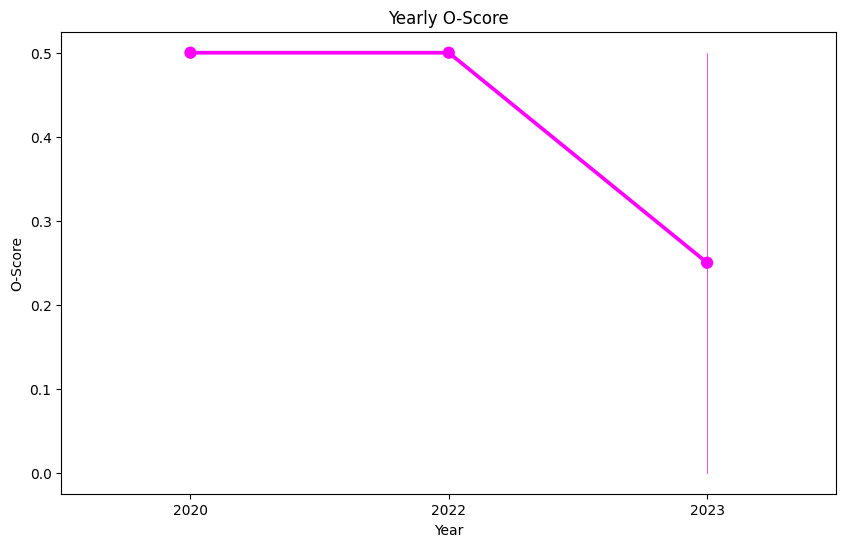

In [9]:
#Calculate your o-index by typing your name as the first argument in the get_openness function
o_df = get_openness("jennifer jahncke", "o-index-shiny/apikey.txt")
print(f"Your o-index is: {oindex(o_df)}")

plt.figure(figsize=(10, 6))
ax = sns.pointplot(data = o_df.sort_values(by ='year'), x= 'year', y= 'o-score', color = 'magenta', errwidth=0.5)
ax.set(xlabel='Year',
       ylabel='O-Score',
       title='Yearly O-Score')
ax;
o_df